In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
!nvidia-smi | grep 300W

| 30%   44C    P2              80W / 300W |   1297MiB / 49140MiB |      5%      Default |
| 30%   31C    P8              28W / 300W |  13253MiB / 49140MiB |      0%      Default |
| 30%   31C    P8              23W / 300W |     12MiB / 49140MiB |      0%      Default |
| 30%   31C    P8              17W / 300W |  22353MiB / 49140MiB |      0%      Default |
| 50%   75C    P2             292W / 300W |  35619MiB / 49140MiB |     96%      Default |
| 42%   71C    P2             257W / 300W |   6769MiB / 49140MiB |    100%      Default |
| 30%   45C    P2              88W / 300W |   4958MiB / 49140MiB |     27%      Default |
| 30%   49C    P2              99W / 300W |   6060MiB / 49140MiB |     34%      Default |


In [3]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
pathPrefix ="../data/"

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt

In [5]:
# !pip install torchvision

In [6]:
seed = 0
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
np.random.seed(seed)
torch.manual_seed(seed)

In [114]:
# class SimpleCNN(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.conv1 = nn.Conv2d(1, 16, 3, padding=1)
#         self.fc = nn.Linear(16 * 28 * 28, 10)

#     def forward(self, x):
#         x = torch.relu(self.conv1(x))
#         x = x.view(-1, 16 * 28 * 28)
#         return self.fc(x)

# from https://medium.com/@deepeshdeepakdd2/lenet-5-implementation-on-mnist-in-pytorch-c6f2ee306e37
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.feature = nn.Sequential(
            #1
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1, padding=2),   # 28*28->32*32-->28*28
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2, stride=2),  # 14*14
            
            #2
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1),  # 10*10
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2, stride=2),  # 5*5
            
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=16*5*5, out_features=120),
            nn.Tanh(),
            nn.Linear(in_features=120, out_features=84),
            nn.Tanh(),
            nn.Linear(in_features=84, out_features=10),
        )
        
    def forward(self, x):
        return self.classifier(self.feature(x))

In [115]:
def create_fixed_class_client_loaders(num_clients=4, k=5, batch_size=32):  #checked
    
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])

    dataset = datasets.MNIST(root="./data", train=True, download=True, transform=transform)

    # Build class indices
    class_indices = defaultdict(list)
    for idx, (_, label) in enumerate(dataset):
        class_indices[label].append(idx)
    
    for c in class_indices:
        np.random.shuffle(class_indices[c])

    # Assign exactly k unique classes to each client
    all_classes = np.arange(10)
    client_classes = [np.random.choice(all_classes, size=k, replace=False) for _ in range(num_clients)]

    client_indices = [[] for _ in range(num_clients)]

    # Distribute samples of each class to clients that need it
    for class_id in range(10):
    
        # Clients that selected this class
        clients_with_class = [cid for cid, classes in enumerate(client_classes) if class_id in classes]
        if not clients_with_class:
            continue

        # Split class data among those clients
        splits = np.array_split(class_indices[class_id], len(clients_with_class))
        for cid, split in zip(clients_with_class, splits):
            client_indices[cid].extend(split.tolist())

    client_loaders = []
    for indices in client_indices:
        if not indices:
            indices = [0] 
        loader = DataLoader(
            Subset(dataset, indices),
            batch_size=batch_size,
            shuffle=True,
            num_workers=2,
            pin_memory=True,
            drop_last=True
        )
        client_loaders.append(loader)
    return client_loaders, client_classes


In [116]:
def train_local(model, loader, optimizer, device, epochs=1, r=-1, lr = 0.01): #checked
    model.train()
    criterion = nn.CrossEntropyLoss()    
    optimizer = optim.SGD(model.parameters(), lr=lr)
    for _ in range(epochs):
        for j, (data, target) in enumerate(loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            if r>=0:
                if j>=r:
                    return

In [117]:
def train_server(server_model, avg_logits, common_data, optimizer, epochs=1): #checked
    server_model.train()
    criterion = nn.KLDivLoss(reduction="batchmean")

    for _ in range(epochs):
        for x, y in zip(common_data, avg_logits):
            optimizer.zero_grad()
            log_prob = F.log_softmax(server_model(x), dim=-1)
            loss = criterion(log_prob, y)
            loss.backward()
            optimizer.step()

In [118]:
def evaluate(model, test_loader, device): #checked
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            total += target.size(0)
    return correct / total

In [242]:
def zero_out_uncertain_logits(logits_list, threshold=1.2):  #checked
    stacked = torch.stack(logits_list)        # [M, B, C]
    # Compute entropy per model per sample
    probs = F.softmax(stacked, dim=-1)        # [M, B, C]
    entropy = -(probs * probs.log()).sum(dim=-1)   # [M, B]

    # Mask: True if confident
    mask = (entropy < threshold).float()      # [M, B]

    # Expand mask to logits shape
    mask_expanded = mask.unsqueeze(-1)        # [M, B, 1]

    # Zero out uncertain logits
    masked_logits = stacked * mask_expanded   # [M, B, C]

    # Count how many models contributed per sample
    denom = mask.sum(dim=0).unsqueeze(-1).clamp(min=1)  # [B, 1]

    # Average only over confident models
    avg_logits = masked_logits.sum(dim=0) / denom       # [B, C]

    masked_probs = probs * mask_expanded
    avg_probs = masked_probs.sum(dim=0) / denom
    return avg_probs, torch.mean(entropy)



            
            


In [369]:
num_clients = 10
batch_size = 64
common_data_size = 512
k = 5
threshold = 3

client_loaders, _ = create_fixed_class_client_loaders(num_clients, batch_size=batch_size, k=k)

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Create a subset with specific indices
indices = list(range(len(test_dataset)))  # e.g., first 1000 samples
np.random.shuffle(indices)
testSubset = Subset(test_dataset, indices[:1000])
commonSubset = Subset(test_dataset, indices[1000:])

# Use with DataLoader
test_loader = torch.utils.data.DataLoader(testSubset, batch_size=batch_size, shuffle=False)
common_loader = torch.utils.data.DataLoader(commonSubset, batch_size=batch_size, shuffle=True,)





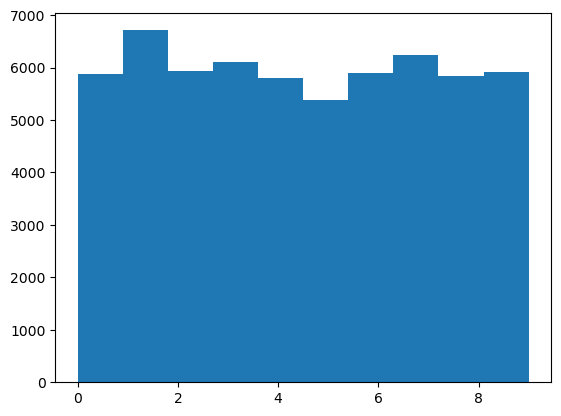

In [370]:
YS=[]
for loader in client_loaders:
    Y=[]
    for x,y in loader:
        Y.append(y)
    YS.append(torch.cat(Y))
Ys = torch.cat(YS)
plt.hist(Ys,10);

In [371]:
local_models = [SimpleCNN().to(device) for _ in range(num_clients)]
server_model = SimpleCNN().to(device)

local_optimizers = [optim.Adam(m.parameters(), lr=0.01) for m in local_models]
server_optimizer = optim.Adam(server_model.parameters(), lr=0.01)


In [372]:
R=-1
LR=0.01
EPOCHS = 3
criterion = nn.KLDivLoss(reduction="batchmean")

In [390]:
for r in range(1):
    Pmax=[]
    local_acc = []
    for i, (model, loader, opt) in enumerate(zip(local_models, client_loaders, local_optimizers)):
        train_local(model, loader, opt, device, epochs=EPOCHS, r=R, lr=LR)
        if i % 5 == 0:
            local_acc.append(evaluate(model, test_loader, device))

    EPOCHS=1
    LR=0.001
    R=-1
    common_data = []
    avg_logits = []
    entropies = []
    
    server_model.train()    
    for model in local_models:
        model.eval()
    for x, _ in common_loader:
        #for _ in range(common_data_size):
            #x = torch.randn(batch_size, 1, 28, 28, device=device)
            x = x.to(device)
            common_data.append(x)
            
            with torch.no_grad():
                local_logits = [m(x).detach() for m in local_models]
                stacked = torch.stack(local_logits)
                probs = F.softmax(stacked, dim=-1) 
                SEL=(torch.max(probs,-1)[0]<0.3)
                P = probs+0.0
                P[SEL] *=0
                P = torch.sum(P,axis=0)
                S=torch.sum(P,1)
                SEL = S>0
                P = P[SEL] * (1/(S[SEL])).view([-1,1])
                Pmax.append(torch.max(P,1)[0].data.cpu())
            if torch.sum(SEL)>0:
                    
                server_optimizer.zero_grad()
                log_prob = F.log_softmax(server_model(x[SEL]), dim=-1)
                loss = criterion(log_prob, P )
                loss.backward()
                server_optimizer.step()


    
    acc = evaluate(server_model, test_loader, device)
    print(f"{r + 1}: Server model accuracy on test set: {acc*100:.2f}%, local models average accuracy before copying: {np.mean(local_acc)*100:.2f}%")
    for model in local_models:
        model.load_state_dict(server_model.state_dict())


1: Server model accuracy on test set: 77.70%, local models average accuracy before copying: 75.65%


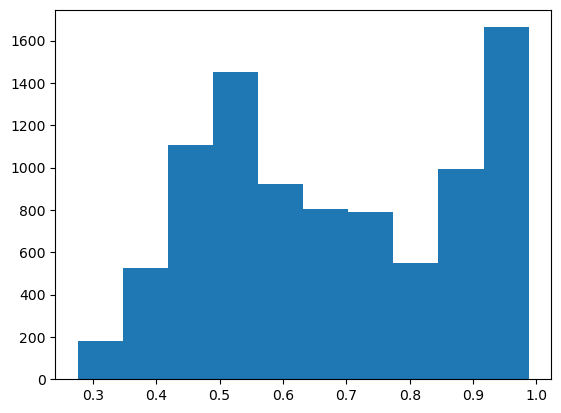

In [393]:
plt.hist(torch.cat(Pmax));

In [379]:
centralized = SimpleCNN().to(device)

centralized_optimizer = optim.Adam(centralized.parameters(), lr=0.01)
model.train()
criterion = nn.CrossEntropyLoss()    

for _ in range(10):
    for j, (data, target) in enumerate(common_loader):
        data, target = data.to(device), target.to(device)
        centralized_optimizer.zero_grad()
        output = centralized(data)
        loss = criterion(output, target)
        loss.backward()
        centralized_optimizer.step()
    acc = evaluate(centralized, test_loader, device)
    print("accuracy centralized", acc)

accuracy centralized 0.928
accuracy centralized 0.951
accuracy centralized 0.944
accuracy centralized 0.965
accuracy centralized 0.972
accuracy centralized 0.961
accuracy centralized 0.947
accuracy centralized 0.973
accuracy centralized 0.96
accuracy centralized 0.962


0.068

In [195]:
for model in local_models:
    model.load_state_dict(server_model.state_dict())
    acc = evaluate(model, test_loader, device)
    print(acc)

0.068
0.068
0.068
0.068
0.068
0.068
0.068
0.068
0.068
0.068


In [193]:
train_local(model, common_loader, opt, device, epochs=1, r=-1, lr=0.01)

In [194]:
acc = evaluate(model, test_loader, device)
print(acc)

0.935


In [177]:
train_local(model, client_loaders[-1], opt, device, epochs=1, r=-1, lr=0.001)

In [178]:
acc = evaluate(model, test_loader, device)
print(acc)

0.687
